In [1]:
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.feature as cfeature
import matplotlib.colors as colors
import numpy as np

from pyorbital.orbital import get_observer_look

In [2]:
save_path = 'figures_and_data'

In [3]:
regions = gpd.read_file('data/Natural_Earth_quick_start/50m_cultural/ne_50m_admin_1_states_provinces_lakes.shp')
states = regions[regions.admin == 'United States of America']
contiguous_us = states[(states.name != 'Alaska') & (states.name != 'Hawaii')]

countries = gpd.read_file('data/Natural_Earth_quick_start/110m_cultural/ne_110m_admin_0_countries.shp')

[compared to this](https://www.researchgate.net/figure/Limb-area-between-the-80-and-90-view-zenith-angle-isolines-of-the-GOES-16-dotted_fig1_353923891)

In [4]:
plate = ccrs.PlateCarree()
equal_area = ccrs.AlbersEqualArea(central_latitude=39.8283, central_longitude=-98.5795)
us_centered_plate = ccrs.PlateCarree(central_longitude=-98.5795)

In [5]:
def get_sat_view_angles_and_labels(goes_imager_projection_attrs, label_projection, 
                                   xs, ys, levels, label_angle_offset = -20):
    satlat = goes_imager_projection_attrs['latitude_of_projection_origin']
    satlon = goes_imager_projection_attrs['longitude_of_projection_origin']
    sath = goes_imager_projection_attrs['perspective_point_height']
    sattime = pd.to_datetime('2021-01-01')
    
    az, el = get_observer_look(
    satlon, satlat, sath/1000,
    sattime,
    xs, ys, 0)

    el = 90 - np.where(el < 0, np.nan, el)
    
    from geographiclib.geodesic import Geodesic

    line = Geodesic.WGS84.Line(
        lat1=satlat,
        lon1=satlon,
        azi1=label_angle_offset
    )

    _xs, _ys = [], []

    for level in np.arange(0, 90.1, 0.05):
        pos = line.ArcPosition(level)
        _xs.append(pos['lon2'])
        _ys.append(pos['lat2'])

    az, angles = get_observer_look(
        satlon, satlat, sath/1000,
        sattime,
        _xs, _ys, 0)
    angles = 90 - angles

    it = iter(levels)
    level = next(it)
    idxs = []
    for idx, a in enumerate(angles):
        if np.isclose(a, level, 0.05):
            idxs.append(idx)
            level = next(it, None)
            if level is None: break

    label_x_locs = np.array(_xs)[idxs]
    label_y_locs = np.array(_ys)[idxs]

    transformed = label_projection.transform_points(x=label_x_locs, y=label_y_locs, src_crs=plate)
    manual = list(zip(transformed[:,0], transformed[:,1]))
    
    return el, manual

In [6]:
def fmt(x):
    return f"{x:.0f}$^\circ$"

# https://stackoverflow.com/a/18926541/5217293
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('inferno')
new_cmap = truncate_colormap(cmap, 0.2, 1.0)

In [7]:
goes17 = {'long_name': 'GOES-R ABI fixed grid projection','grid_mapping_name': 'geostationary','perspective_point_height': 35786023.0,'semi_major_axis': 6378137.0,'semi_minor_axis': 6356752.31414,'inverse_flattening': 298.2572221,'latitude_of_projection_origin': 0.0,'longitude_of_projection_origin': -137.0,'sweep_angle_axis': 'x'}

globe = ccrs.Globe(
    inverse_flattening = goes17['inverse_flattening'],
    semimajor_axis = goes17['semi_major_axis'],
    semiminor_axis = goes17['semi_minor_axis']
)

goes17_proj = ccrs.Geostationary(
    central_longitude=goes17['longitude_of_projection_origin'], 
    satellite_height=goes17['perspective_point_height'], 
    false_easting=0, 
    false_northing=0, 
    globe=globe,
    sweep_axis=goes17['sweep_angle_axis']
)

In [8]:
goes16 = {'long_name': 'GOES-R ABI fixed grid projection','grid_mapping_name': 'geostationary','perspective_point_height': 35786023.0,'semi_major_axis': 6378137.0,'semi_minor_axis': 6356752.31414,'inverse_flattening': 298.2572221,'latitude_of_projection_origin': 0.0,'longitude_of_projection_origin': -75.0,'sweep_angle_axis': 'x'}

globe = ccrs.Globe(
    inverse_flattening = goes16['inverse_flattening'],
    semimajor_axis = goes16['semi_major_axis'],
    semiminor_axis = goes16['semi_minor_axis']
)

goes16_proj = ccrs.Geostationary(
    central_longitude=goes16['longitude_of_projection_origin'], 
    satellite_height=goes16['perspective_point_height'], 
    false_easting=0, 
    false_northing=0, 
    globe=globe,
    sweep_axis=goes16['sweep_angle_axis']
)

In [9]:
xs, ys = np.meshgrid(np.arange(-180, 180), np.arange(-90, 90))

In [10]:
levels = np.arange(10, 81, 10)

goes17_el, goes17_manual = get_sat_view_angles_and_labels(goes17, goes17_proj, xs, ys, levels)
goes16_el, goes16_manual = get_sat_view_angles_and_labels(goes16, goes16_proj, xs, ys, levels)

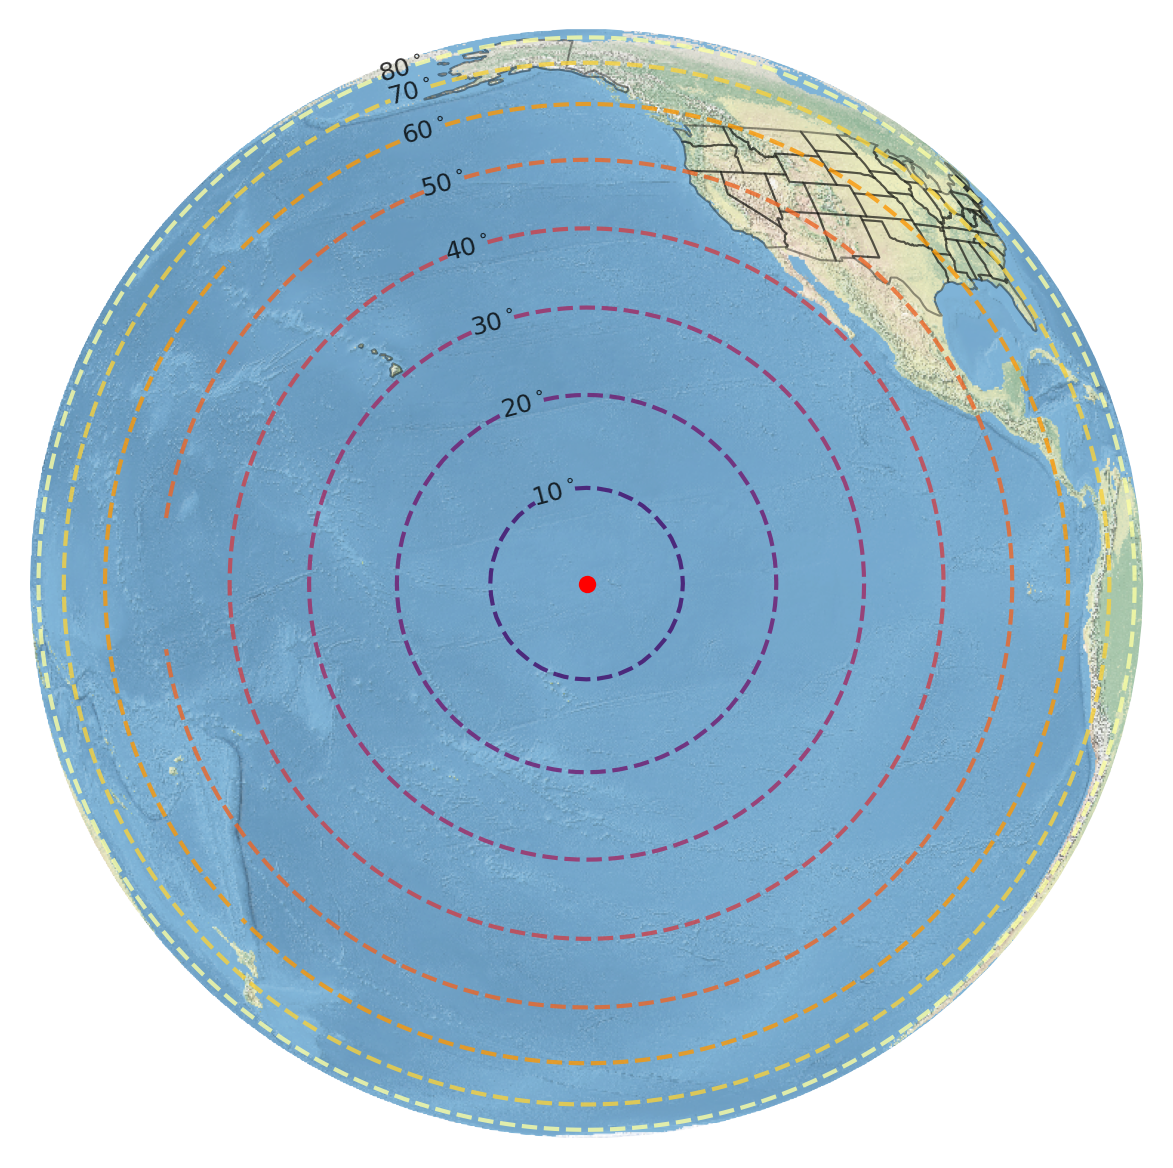

In [11]:
fig, ax = plt.subplots(dpi=300, subplot_kw=dict(projection=goes17_proj))

lw = 1
mappable = ax.contour(xs, ys, goes17_el, 
                      transform=plate, 
                      levels=levels, 
                      cmap=new_cmap, 
                      alpha=0.8,
                      linestyles='--', linewidths=lw)

ax.clabel(mappable, mappable.levels, 
          inline=True, 
          fmt=fmt, 
          fontsize=6, 
          colors='black',
          manual=goes17_manual
         )

fname = 'data/Natural_Earth_quick_start/50m_raster/NE1_50M_SR_W/NE1_50M_SR_W.tif'
img = plt.imread(fname)
ax.imshow(img, origin='upper', extent=[-180, 180, -90, 90], transform=plate)

ax.scatter(goes17['longitude_of_projection_origin'], goes17['latitude_of_projection_origin'], transform=plate, s=10, color='red')
ax.add_feature(cfeature.STATES, lw=0.5, alpha=0.4)
ax.spines[:].set_visible(False)

fig.savefig(f'{save_path}/GOES-17-Zenith-Angle.png', format='png', bbox_inches='tight')

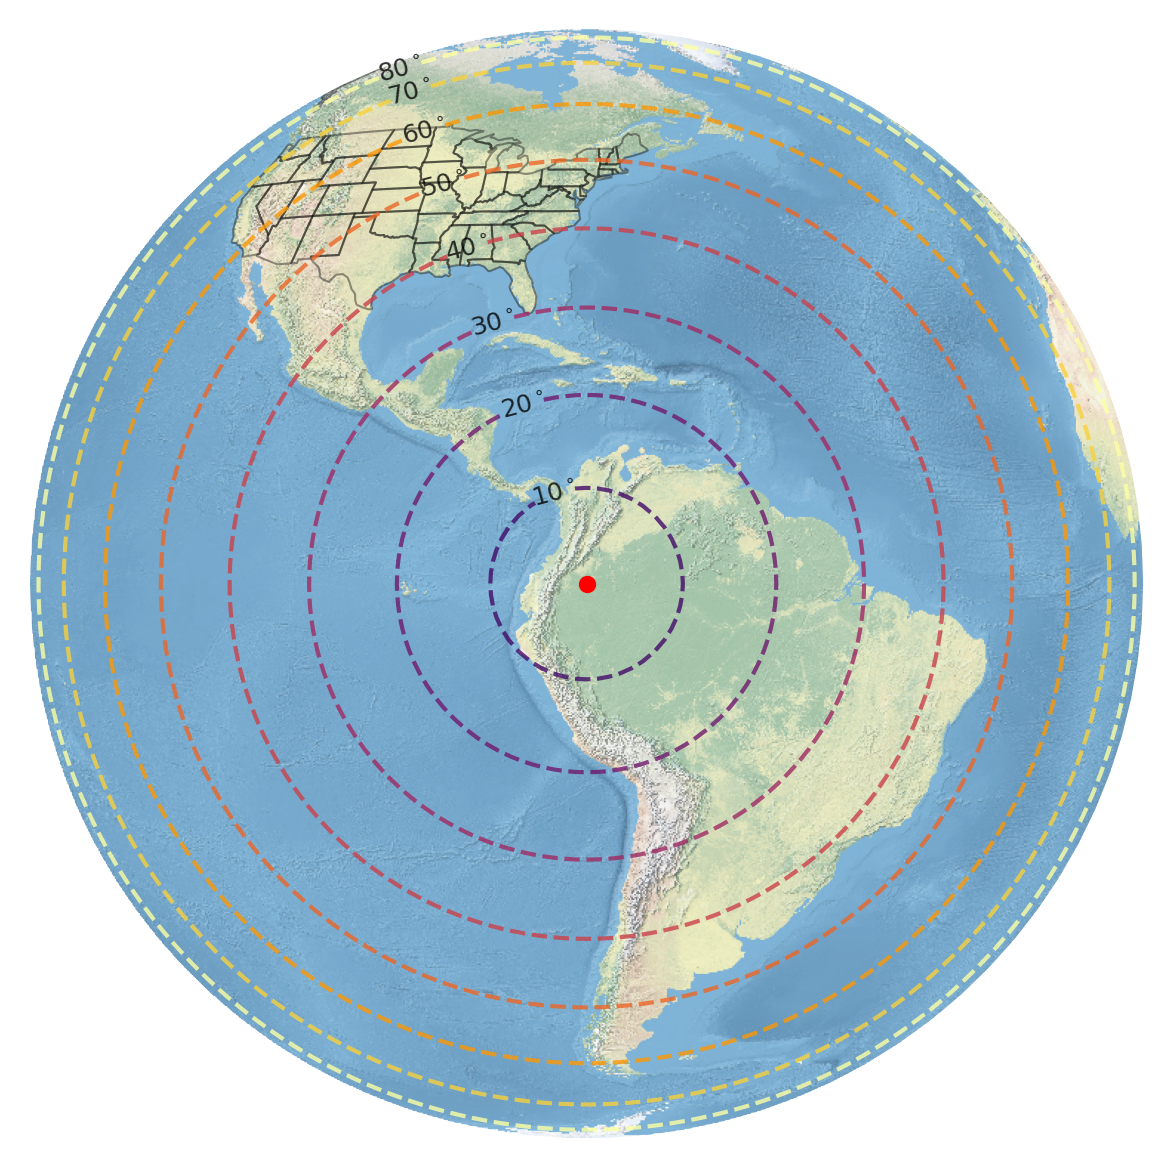

In [12]:
fig, ax = plt.subplots(dpi=300, subplot_kw=dict(projection=goes16_proj))

lw = 1
mappable = ax.contour(xs, ys, goes16_el, 
                      transform=plate, 
                      levels=levels, 
                      cmap=new_cmap, 
                      alpha=0.8,
                      linestyles='--', linewidths=lw)

ax.clabel(mappable, mappable.levels, 
          inline=True, 
          fmt=fmt, 
          fontsize=6, 
          colors='black',
          manual=goes16_manual
         )

fname = 'data/Natural_Earth_quick_start/50m_raster/NE1_50M_SR_W/NE1_50M_SR_W.tif'
img = plt.imread(fname)
ax.imshow(img, origin='upper', extent=[-180, 180, -90, 90], transform=plate)

ax.scatter(goes16['longitude_of_projection_origin'], goes16['latitude_of_projection_origin'], transform=plate, s=10, color='red')
ax.add_feature(cfeature.STATES, lw=0.5, alpha=0.4)
ax.spines[:].set_visible(False)

fig.savefig(f'{save_path}/GOES-16-Zenith-Angle.png', format='png', bbox_inches='tight')

In [13]:
center_geos_proj = ccrs.Geostationary(
    central_longitude=(goes17['longitude_of_projection_origin']+goes16['longitude_of_projection_origin'])/2, 
    satellite_height=goes17['perspective_point_height'], 
    false_easting=0, 
    false_northing=0, 
    globe=globe,
    sweep_axis=goes17['sweep_angle_axis']
)

In [14]:
levels = [30, 40, 50, 60]

g16_dat = get_sat_view_angles_and_labels(goes16, center_geos_proj, xs, ys, levels, label_angle_offset=20)
g17_dat = get_sat_view_angles_and_labels(goes17, center_geos_proj, xs, ys, levels)

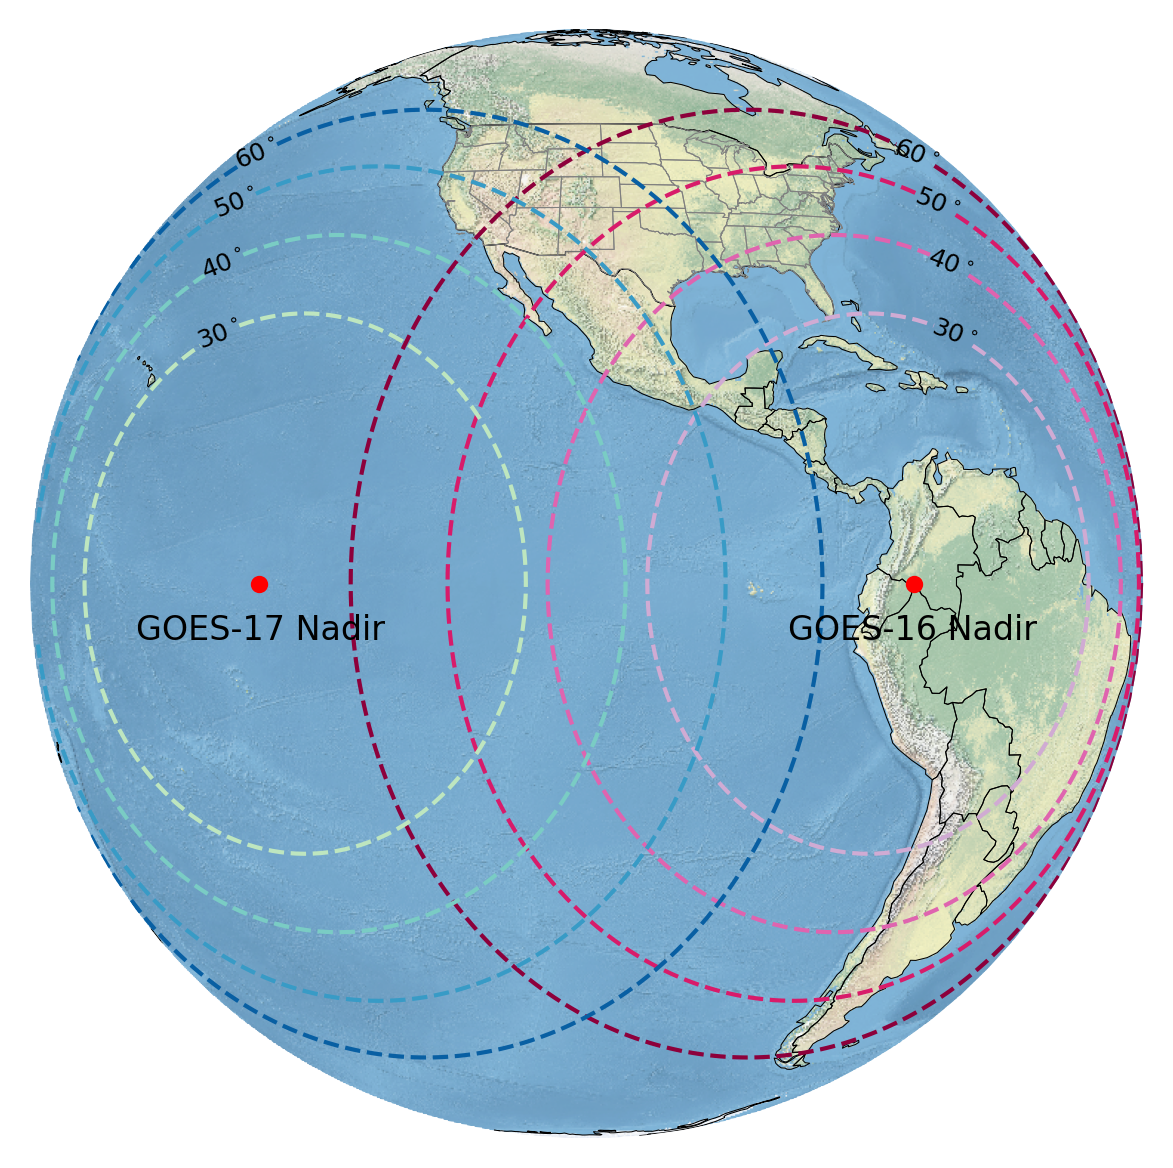

In [35]:
fig, ax = plt.subplots(dpi=300, subplot_kw=dict(projection=center_geos_proj))

lw = 1

for angles, labels, cmap in [(*g16_dat, 'PuRd'), (*g17_dat, 'GnBu')]:
    cmap = plt.get_cmap(cmap)
    new_cmap = truncate_colormap(cmap, 0.3, 0.9)
    mappable = ax.contour(xs, ys, angles, 
                          transform=plate, 
                          levels=levels, 
                          cmap=new_cmap, 
                          alpha=1,
                          linestyles='--', linewidths=lw)

    ax.clabel(mappable, mappable.levels, 
              inline=True, 
              fmt=fmt, 
              fontsize=6, 
              colors='black',
              manual=labels
             )
    
fname = 'data/Natural_Earth_quick_start/50m_raster/NE1_50M_SR_W/NE1_50M_SR_W.tif'
img = plt.imread(fname)
ax.imshow(img, origin='upper', extent=[-180, 180, -90, 90], transform=plate)

countries.plot(facecolor='None', ax=ax, transform=plate, lw=0.25)
contiguous_us.plot(facecolor='None', edgecolor='gray', ax=ax, transform=plate, lw=0.25)

for proj, label in [(goes17, "GOES-17 Nadir"), (goes16, "GOES-16 Nadir")]:
    x, y = proj['longitude_of_projection_origin'], proj['latitude_of_projection_origin']
    ax.scatter(x, y, transform=plate, s=10, color='red')
    ax.text(x, y-5, label, transform=plate, size=8, fontdict=dict(ha='center'))
    
ax.spines[:].set_visible(False)
# ax.coastlines()
# ax.set_extent([-192, -20, -60, 60], plate)
ax.set_aspect('equal')

# fig.savefig(f'{save_path}/GOES-16-17-Zenith-Angle.png', format='png', bbox_inches='tight')

### To Show on top of GOES geotiff

In [14]:
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = 933120000
import rioxarray

# fname = '/Users/kyle/Downloads/20222781650_GOES16-ABI-FD-GEOCOLOR-10848x10848.tif'
# img = plt.imread(fname)
# xds = rioxarray.open_rasterio(fname)
# extent = [xds.x.min().item(), xds.x.max().item(), xds.y.min().item(), xds.y.max().item()]
# ax.imshow(img, origin='upper', extent=extent, transform=ccrs.PlateCarree())

# save_path = '/Users/kyle/GoogleDrive/College/Graduate/Thesis/Figures and Data/tuned_models'
# fig.savefig(f'{save_path}/GOES-Zenith-Angle.png', format='png', bbox_inches='tight')